In [31]:
import zipfile
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

Download and unzip file

In [2]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

# zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
# zip_ref.extractall()
# zip_ref.close()

Data preparation & preprocessing

In [3]:
train_path = pathlib.Path("pizza_steak/train/")
class_names = np.array(sorted([item.name for item in train_path.glob('*')]))

print('Type of classes: ', class_names)

Type of classes:  ['pizza' 'steak']


In [4]:
def view_random_image(target_path, target_class):
    target_folder = target_path + target_class

    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");
    
    print(f"Image shape: {img.shape}")

    return img

In [27]:
def plot_loss_curves(history):
    print(history)
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    plt.plot(epochs, loss, label = 'training_loss')
    plt.plot(epochs, val_loss, label = 'val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label  ='training_accuracy')
    plt.plot(epochs, val_accuracy, label = 'val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [89]:
def load_and_prep_image(filename, img_shape = 224):
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img, channels = 3)
    img = tf.image.resize(img, size = [img_shape, img_shape])
    img = img/255.
    
    return img

In [99]:
def pred_and_plot(model, filename, class_names):
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    pred_class = class_names[int(tf.round(pred)[0][0])]

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

Image shape: (512, 512, 3)


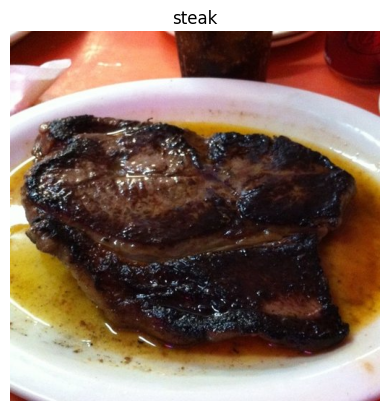

In [5]:
img = view_random_image(target_path = "pizza_steak/train/", target_class = "steak")

In [6]:
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))

print('number of train for steak`s image: ', num_steak_images_train)

number of train for steak`s image:  750


Image shape: (512, 512, 3)
Image shape: (384, 512, 3)


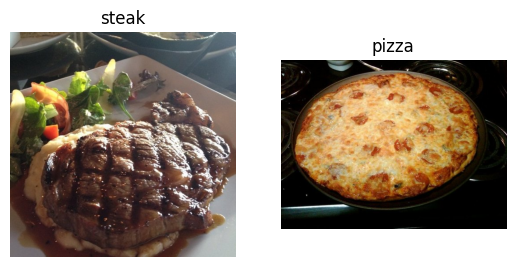

In [7]:
plt.figure()

plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")

plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

In [8]:
train_path = "pizza_steak/train/"
test_path = "pizza_steak/test/"

train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_data = train_datagen.flow_from_directory(train_path, batch_size = 32, target_size = (224, 224), 
    class_mode = "binary", seed = 42)
valid_data = train_datagen.flow_from_directory(test_path, batch_size = 32, target_size = (224, 224), 
    class_mode = "binary", seed = 42)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


First model

In [9]:
tf.random.set_seed(42)

first_model = tf.keras.models.Sequential([
    ### First layer
    tf.keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = "relu", input_shape = (224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(pool_size = 2, padding = "valid"),
    ### Second layer
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(2),
    ### Flatten layer
    tf.keras.layers.Flatten(),
    ### Output/ Fully connected layer
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

first_model.summary()

first_model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

In [10]:
first_history = first_model.fit(train_data, epochs = 5, 
    steps_per_epoch = len(train_data), validation_data = valid_data, validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 40s 833ms/step - loss: 0.5702 - accuracy: 0.6980 - val_loss: 0.3858 - val_accuracy: 0.8500
Epoch 2/5
47/47 [==============================] - 37s 788ms/step - loss: 0.4533 - accuracy: 0.7867 - val_loss: 0.3550 - val_accuracy: 0.8680
Epoch 3/5
47/47 [==============================] - 36s 772ms/step - loss: 0.3976 - accuracy: 0.8313 - val_loss: 0.3333 - val_accuracy: 0.8780
Epoch 4/5
47/47 [==============================] - 37s 779ms/step - loss: 0.3749 - accuracy: 0.8393 - val_loss: 0.3340 - val_accuracy: 0.8560
Epoch 5/5
47/47 [==============================] - 39s 824ms/step - loss: 0.3399 - accuracy: 0.8513 - val_loss: 0.3188 - val_accuracy: 0.8780


Second model

In [11]:
second_model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape = (224, 224, 3)),
  tf.keras.layers.Dense(4, activation = 'relu'),
  tf.keras.layers.Dense(4, activation = 'relu'),
  tf.keras.layers.Dense(1, activation = 'sigmoid')
])

second_model.summary()

second_model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602141 (2.30 MB)
Trainable params: 602141 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
second_history = second_model.fit(train_data, epochs = 5, steps_per_epoch = len(train_data), 
    validation_data = valid_data, validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 8s 151ms/step - loss: 0.6215 - accuracy: 0.6860 - val_loss: 0.5824 - val_accuracy: 0.7560
Epoch 2/5
47/47 [==============================] - 8s 168ms/step - loss: 0.5742 - accuracy: 0.7533 - val_loss: 0.5878 - val_accuracy: 0.7520
Epoch 3/5
47/47 [==============================] - 7s 145ms/step - loss: 0.5805 - accuracy: 0.7267 - val_loss: 0.6387 - val_accuracy: 0.6200
Epoch 4/5
47/47 [==============================] - 7s 145ms/step - loss: 0.5667 - accuracy: 0.7520 - val_loss: 0.5880 - val_accuracy: 0.7040
Epoch 5/5
47/47 [==============================] - 6s 132ms/step - loss: 0.5437 - accuracy: 0.7707 - val_loss: 0.5366 - val_accuracy: 0.7780


Third model

In [13]:
third_model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape = (224, 224, 3)),
  tf.keras.layers.Dense(100, activation = 'relu'),
  tf.keras.layers.Dense(100, activation = 'relu'),
  tf.keras.layers.Dense(1, activation = 'sigmoid')
])

third_model.summary()

third_model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy"])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15063101 (57.46 MB)
Trainable params: 15063101 (57.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
third_history = third_model.fit(train_data, epochs = 5, steps_per_epoch = len(train_data), 
    validation_data = valid_data, validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 13s 277ms/step - loss: 3.3328 - accuracy: 0.6293 - val_loss: 0.8927 - val_accuracy: 0.6500
Epoch 2/5
47/47 [==============================] - 13s 271ms/step - loss: 0.8003 - accuracy: 0.6907 - val_loss: 0.6240 - val_accuracy: 0.7260
Epoch 3/5
47/47 [==============================] - 14s 291ms/step - loss: 0.7845 - accuracy: 0.7073 - val_loss: 0.5165 - val_accuracy: 0.7880
Epoch 4/5
47/47 [==============================] - 13s 271ms/step - loss: 0.6613 - accuracy: 0.7500 - val_loss: 0.4445 - val_accuracy: 0.7880
Epoch 5/5
47/47 [==============================] - 13s 281ms/step - loss: 0.4501 - accuracy: 0.7973 - val_loss: 0.4599 - val_accuracy: 0.7860


Forth model

In [37]:
forth_model = Sequential([
  Conv2D(filters = 10, 
         kernel_size = 3, 
         strides = 1,
         padding = 'valid',
         activation = 'relu', 
         input_shape = (224, 224, 3)),
  Conv2D(10, 3, activation = 'relu'),
  Conv2D(10, 3, activation = 'relu'),
  Flatten(),
  Dense(1, activation='sigmoid')
])

forth_model.summary()

forth_model.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_20 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 conv2d_21 (Conv2D)          (None, 218, 218, 10)      910       
                                                                 
 flatten_8 (Flatten)         (None, 475240)            0         
                                                                 
 dense_12 (Dense)            (None, 1)                 475241    
                                                                 
Total params: 477341 (1.82 MB)
Trainable params: 477341 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
forth_history = forth_model.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 47s 978ms/step - loss: 0.5858 - accuracy: 0.7153 - val_loss: 0.3608 - val_accuracy: 0.8520
Epoch 2/5
47/47 [==============================] - 47s 994ms/step - loss: 0.3749 - accuracy: 0.8393 - val_loss: 0.3337 - val_accuracy: 0.8580
Epoch 3/5
47/47 [==============================] - 48s 1s/step - loss: 0.2467 - accuracy: 0.9133 - val_loss: 0.3393 - val_accuracy: 0.8500
Epoch 4/5
47/47 [==============================] - 44s 940ms/step - loss: 0.1304 - accuracy: 0.9633 - val_loss: 0.4966 - val_accuracy: 0.8020
Epoch 5/5
47/47 [==============================] - 47s 996ms/step - loss: 0.0544 - accuracy: 0.9913 - val_loss: 0.3393 - val_accuracy: 0.8560


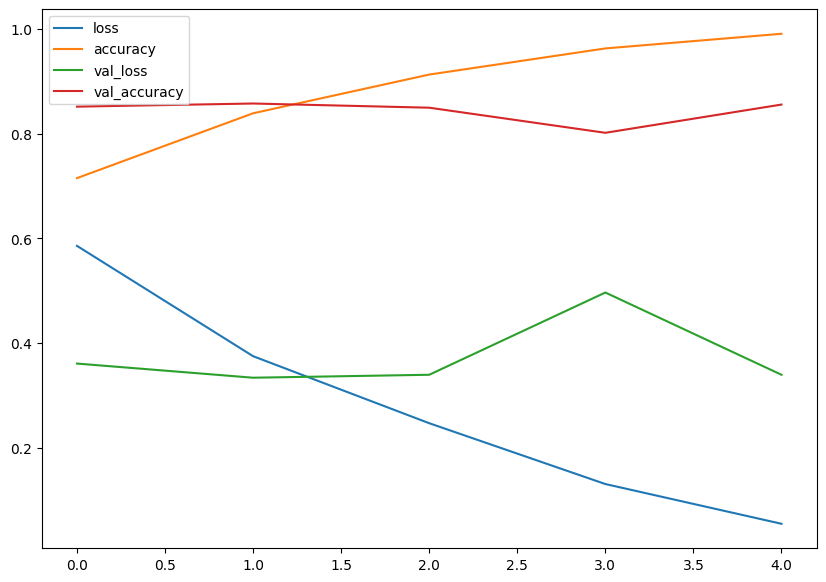

In [41]:
pd.DataFrame(forth_history.history).plot(figsize=(10, 7));

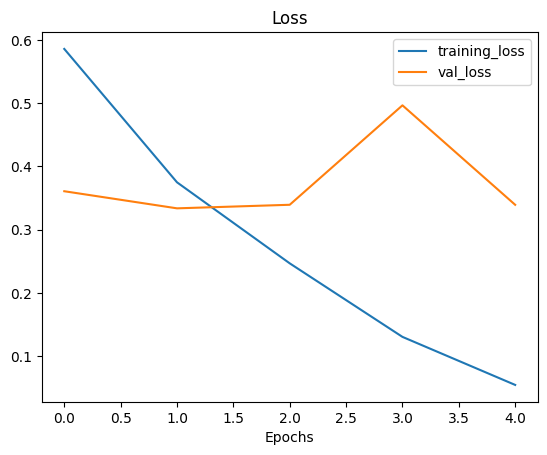

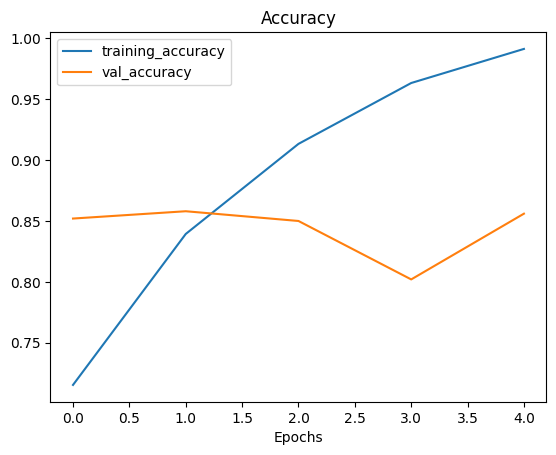

In [42]:
plot_loss_curves(forth_history)

Fifth model

In [47]:
fifth_model = Sequential([
  Conv2D(10, 3, activation = 'relu', input_shape = (224, 224, 3)),
  MaxPool2D(pool_size = 2),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation = 'sigmoid')
])

fifth_model.summary()

fifth_model.compile(loss = 'binary_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 111, 111, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 54, 54, 10)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 26, 26, 10)      

In [48]:
fifth_history = fifth_model.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 19s 387ms/step - loss: 0.6609 - accuracy: 0.5913 - val_loss: 0.5501 - val_accuracy: 0.7220
Epoch 2/5
47/47 [==============================] - 16s 345ms/step - loss: 0.4990 - accuracy: 0.7753 - val_loss: 0.4080 - val_accuracy: 0.8280
Epoch 3/5
47/47 [==============================] - 17s 353ms/step - loss: 0.4311 - accuracy: 0.7933 - val_loss: 0.3718 - val_accuracy: 0.8360
Epoch 4/5
47/47 [==============================] - 16s 342ms/step - loss: 0.3925 - accuracy: 0.8193 - val_loss: 0.3623 - val_accuracy: 0.8440
Epoch 5/5
47/47 [==============================] - 17s 350ms/step - loss: 0.3792 - accuracy: 0.8293 - val_loss: 0.3392 - val_accuracy: 0.8620


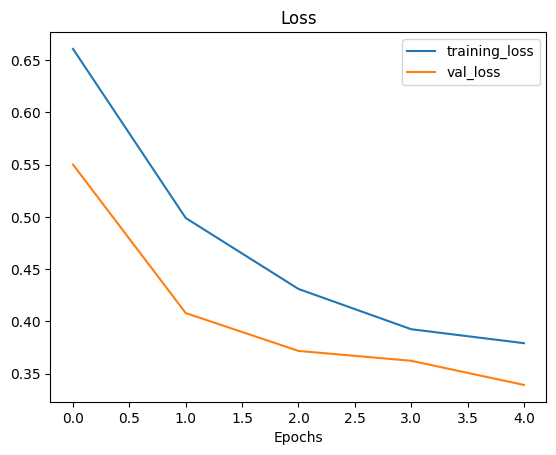

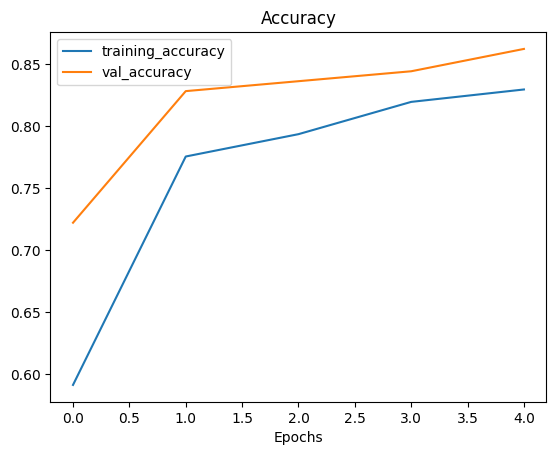

In [49]:
plot_loss_curves(fifth_history)

Data augmentation

In [66]:
train_datagen_augmented = ImageDataGenerator(rescale = 1/255.,
                                             rotation_range = 20,
                                             shear_range = 0.2,
                                             zoom_range = 0.2,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             horizontal_flip = True)

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

In [70]:
train_data_augmented = train_datagen_augmented.flow_from_directory(train_path,
                                                                   target_size = (224, 224),
                                                                   batch_size = 32,
                                                                   class_mode = 'binary',
                                                                   shuffle = False)
train_data = train_datagen.flow_from_directory(train_path,
                                               target_size = (224, 224),
                                               batch_size = 32,
                                               class_mode = 'binary',
                                               shuffle = False)

test_data = test_datagen.flow_from_directory(test_path,
                                             target_size = (224, 224),
                                             batch_size = 32,
                                             class_mode = 'binary')

Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


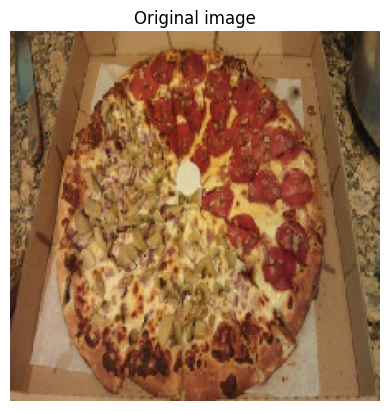

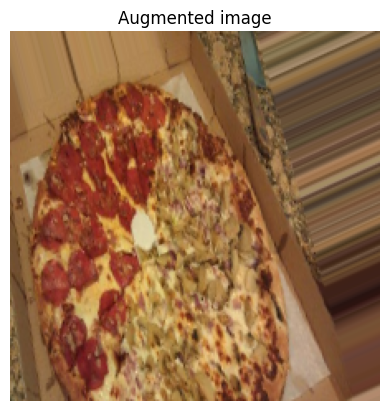

In [71]:
### Original image vs augmented image
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() 

random_number = random.randint(0, 31)
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

Sixth model

In [74]:
sixth_model = Sequential([
  Conv2D(10, 3, activation = 'relu', input_shape = (224, 224, 3)),
  MaxPool2D(pool_size = 2),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation = 'sigmoid')
])

sixth_model.summary()

sixth_model.compile(loss = 'binary_crossentropy',
                optimizer = Adam(),
                metrics=['accuracy'])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 111, 111, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 54, 54, 10)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 26, 26, 10)      

In [75]:
sixth_history = sixth_model.fit(train_data_augmented,
                        epochs = 5,
                        steps_per_epoch = len(train_data_augmented),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 29s 593ms/step - loss: 0.7009 - accuracy: 0.4727 - val_loss: 0.6912 - val_accuracy: 0.5480
Epoch 2/5
47/47 [==============================] - 27s 578ms/step - loss: 0.6969 - accuracy: 0.4960 - val_loss: 0.6907 - val_accuracy: 0.5780
Epoch 3/5
47/47 [==============================] - 27s 570ms/step - loss: 0.6979 - accuracy: 0.5713 - val_loss: 0.6856 - val_accuracy: 0.5320
Epoch 4/5
47/47 [==============================] - 28s 586ms/step - loss: 0.6994 - accuracy: 0.5233 - val_loss: 0.6911 - val_accuracy: 0.5680
Epoch 5/5
47/47 [==============================] - 27s 575ms/step - loss: 0.6921 - accuracy: 0.5600 - val_loss: 0.6889 - val_accuracy: 0.6380


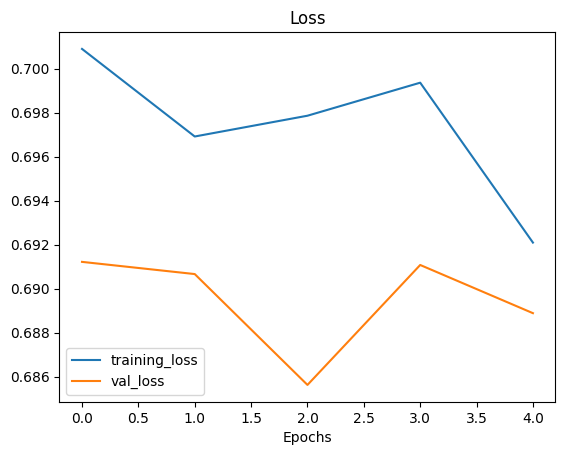

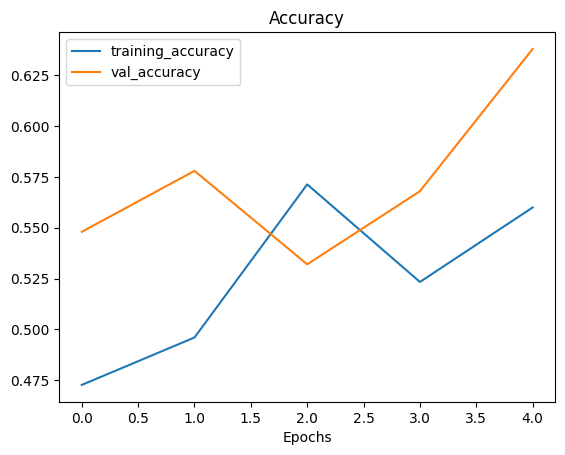

In [76]:
plot_loss_curves(sixth_history)

In [77]:
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_path,
                                                                            target_size = (224, 224),
                                                                            batch_size = 32,
                                                                            class_mode = 'binary',
                                                                            shuffle = True)

Found 1500 images belonging to 2 classes.


In [80]:
seventh_model = Sequential([
  Conv2D(10, 3, activation = 'relu', input_shape = (224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation = 'sigmoid')
])

seventh_model.summary()

seventh_model.compile(loss = 'binary_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 111, 111, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 54, 54, 10)        0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 26, 26, 10)      

In [82]:
seventh_history = seventh_model.fit(train_data_augmented_shuffled,
                        epochs = 5,
                        steps_per_epoch = len(train_data_augmented_shuffled),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 29s 596ms/step - loss: 0.6774 - accuracy: 0.5927 - val_loss: 0.6152 - val_accuracy: 0.5860
Epoch 2/5
47/47 [==============================] - 28s 582ms/step - loss: 0.5812 - accuracy: 0.6987 - val_loss: 0.5110 - val_accuracy: 0.7180
Epoch 3/5
47/47 [==============================] - 27s 580ms/step - loss: 0.5185 - accuracy: 0.7613 - val_loss: 0.3733 - val_accuracy: 0.8460
Epoch 4/5
47/47 [==============================] - 30s 637ms/step - loss: 0.4908 - accuracy: 0.7560 - val_loss: 0.3889 - val_accuracy: 0.8420
Epoch 5/5
47/47 [==============================] - 29s 607ms/step - loss: 0.4928 - accuracy: 0.7733 - val_loss: 0.3440 - val_accuracy: 0.8640


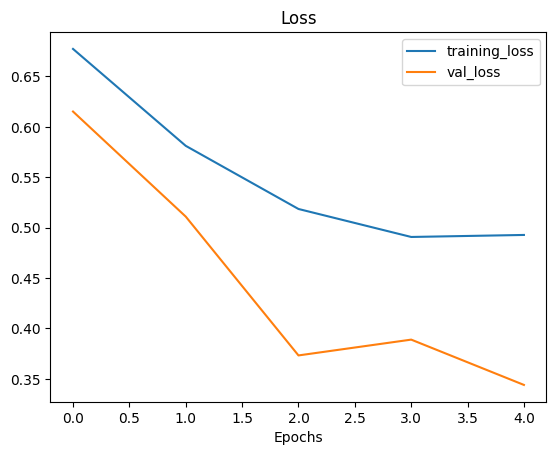

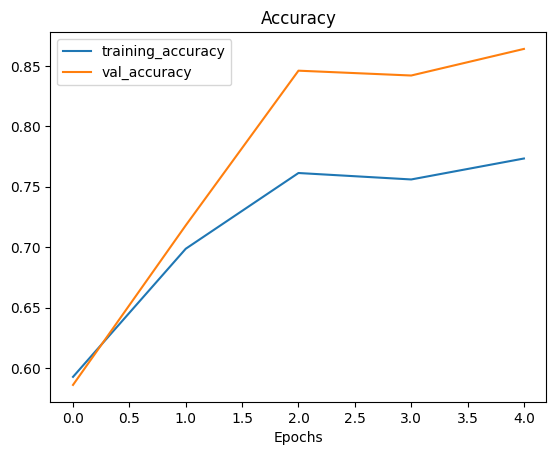

In [83]:
plot_loss_curves(seventh_history)

Eight model

In [84]:
eight_model = Sequential([
  Conv2D(10, 3, activation = 'relu', input_shape = (224, 224, 3)),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation = 'relu'),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation = 'sigmoid')
])

eight_model.summary()

eight_model.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_50 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 110, 110, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_52 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 53, 53, 10)        0         
 ng2D)                                               

In [85]:
eight_history = eight_model.fit(train_data_augmented_shuffled,
                        epochs = 5,
                        steps_per_epoch = len(train_data_augmented_shuffled),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 42s 872ms/step - loss: 0.6792 - accuracy: 0.5980 - val_loss: 0.5637 - val_accuracy: 0.7860
Epoch 2/5
47/47 [==============================] - 40s 852ms/step - loss: 0.5722 - accuracy: 0.7120 - val_loss: 0.4394 - val_accuracy: 0.8300
Epoch 3/5
47/47 [==============================] - 40s 849ms/step - loss: 0.5277 - accuracy: 0.7447 - val_loss: 0.3887 - val_accuracy: 0.8320
Epoch 4/5
47/47 [==============================] - 42s 879ms/step - loss: 0.4853 - accuracy: 0.7660 - val_loss: 0.4028 - val_accuracy: 0.8320
Epoch 5/5
47/47 [==============================] - 43s 907ms/step - loss: 0.5064 - accuracy: 0.7633 - val_loss: 0.3974 - val_accuracy: 0.8300


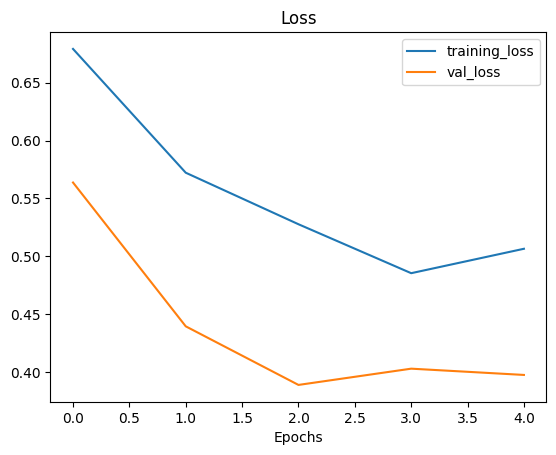

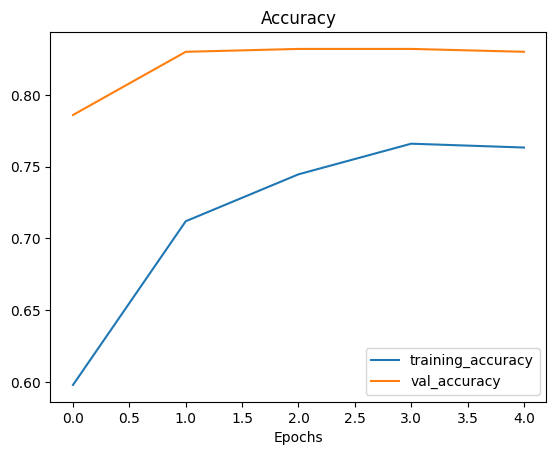

In [86]:
plot_loss_curves(eight_history)

Make prediction

--2023-09-12 21:27:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8002::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: '03-steak.jpeg'

     0K .......... .......... .......... .......... ..........  2% 2.70M 1s
    50K .......... .......... .......... .......... ..........  5% 2.36M 1s
   100K .......... .......... .......... .......... ..........  7% 2.48M 1s
   150K .......... .......... .......... .......... .......... 10% 4.02M 1s
   200K .......... .......... .......... .......... .......... 12% 2.76M 1s
   250K .......... .......... .......... .......... .......... 15% 7.13M 1s
   300K .......... .......... .......... .......... .......... 18% 6.29M

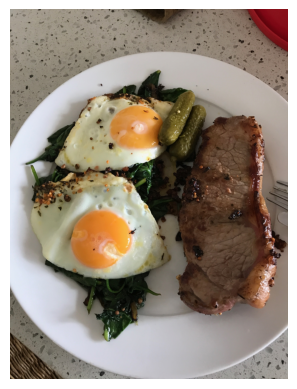

In [87]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg 
    
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [91]:
steak.shape

TensorShape([1, 224, 224, 3])

In [93]:
steak = load_and_prep_image("03-steak.jpeg")
steak.shape

TensorShape([224, 224, 3])

In [94]:
steak = tf.expand_dims(steak, axis = 0)
steak.shape

TensorShape([1, 224, 224, 3])

In [95]:
pred = sixth_model.predict(steak)
pred

1/1 [==============================] - 0s 164ms/step


array([[0.50036025]], dtype=float32)

In [96]:
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'steak'

1/1 [==============================] - 0s 62ms/step


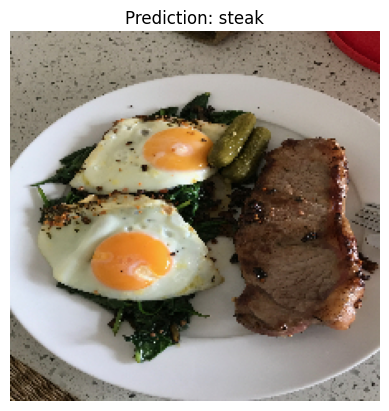

In [101]:
pred_and_plot(eight_model, "03-steak.jpeg", class_names)

1/1 [==============================] - 0s 37ms/step


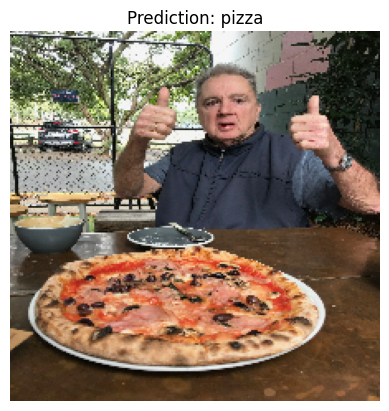

In [103]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg

pred_and_plot(eight_model, "03-pizza-dad.jpeg", class_names)

Multiclass

In [104]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
# zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
# zip_ref.extractall()
# zip_ref.close()

--2023-09-12 21:31:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4001:809::201b, 2404:6800:4001:80f::201b, 2404:6800:4001:801::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4001:809::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: '10_food_classes_all_data.zip'

     0K .......... .......... .......... .......... ..........  0%  173K 48m50s
    50K .......... .......... .......... .......... ..........  0%  201K 45m28s
   100K .......... .......... .......... .......... ..........  0%  515K 35m46s
   150K .......... .......... .......... .......... ..........  0%  477K 31m15s
   200K .......... .......... .......... .......... ..........  0%  680K 27m29s
   250K .......... .......... .......... .......... ..........  0%  892K 24m29s
   300K .......... ........

In [105]:
train_path = "10_food_classes_all_data/train/"
test_path = "10_food_classes_all_data/test/"

In [106]:
data_dir = pathlib.Path(train_path)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


Image shape: (341, 512, 3)


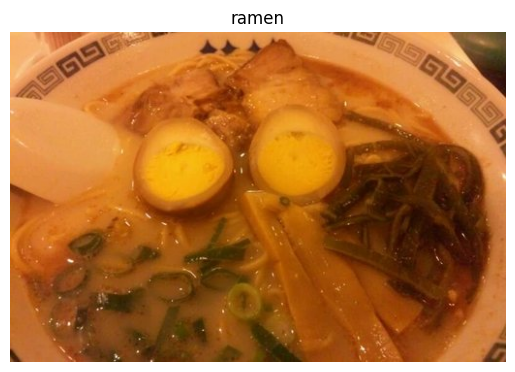

In [108]:
img = view_random_image(target_path = train_path,
                        target_class = random.choice(class_names))

In [110]:
train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

train_data = train_datagen.flow_from_directory(train_path,
                                               target_size = (224, 224),
                                               batch_size = 32,
                                               class_mode = 'categorical')

test_data = train_datagen.flow_from_directory(test_path,
                                              target_size = (224, 224),
                                              batch_size = 32,
                                              class_mode = 'categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


Ninth model

In [112]:
ninth_model = Sequential([
  Conv2D(10, 3, activation = 'relu', input_shape = (224, 224, 3)),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation = 'relu'),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation = 'softmax')
])

ninth_model.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

ninth_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_58 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 110, 110, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_59 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_60 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 53, 53, 10)        0         
 ng2D)                                               

In [113]:
ninth_history = ninth_model.fit(train_data, 
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 187s 791ms/step - loss: 2.2050 - accuracy: 0.1868 - val_loss: 2.0029 - val_accuracy: 0.2860
Epoch 2/5
235/235 [==============================] - 187s 797ms/step - loss: 1.9144 - accuracy: 0.3364 - val_loss: 1.8949 - val_accuracy: 0.3288
Epoch 3/5
235/235 [==============================] - 188s 798ms/step - loss: 1.7119 - accuracy: 0.4165 - val_loss: 1.9025 - val_accuracy: 0.3372
Epoch 4/5
235/235 [==============================] - 190s 807ms/step - loss: 1.2784 - accuracy: 0.5745 - val_loss: 2.1209 - val_accuracy: 0.3072
Epoch 5/5
235/235 [==============================] - 191s 812ms/step - loss: 0.6793 - accuracy: 0.7792 - val_loss: 2.7364 - val_accuracy: 0.3068


In [114]:
ninth_model.evaluate(test_data)

79/79 [==============================] - 17s 213ms/step - loss: 2.7364 - accuracy: 0.3068


[2.7363719940185547, 0.3068000078201294]

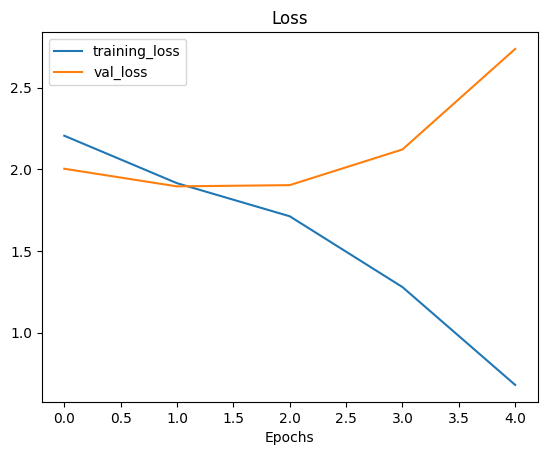

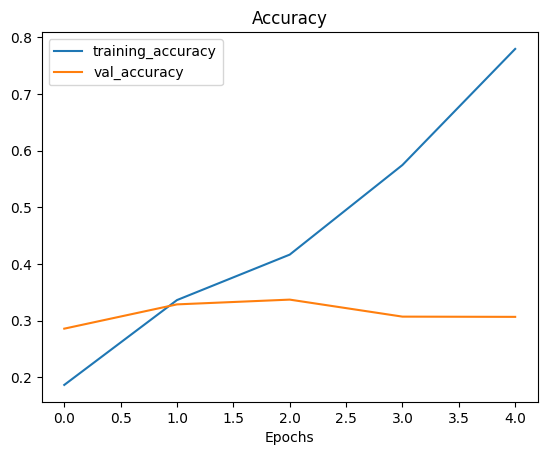

In [115]:
plot_loss_curves(ninth_history)